In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust

In [2]:
sns.set_style('darkgrid')

In [3]:
# obtain data from unphased callset - only needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]
callset_pass

Group(/, 6)
  arrays: 1; samples
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [4]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
callset_phased

<HDF5 file "ag1000g.phase1.ar3.1.haplotypes.h5" (mode r)>

In [5]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 5000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,281826,281827,281828,281829,281830
44688,44691,44732,44736,44756,...,4996563,4996572,4996573,4996579,4996582


In [6]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

281831

In [7]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ..., (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), (b'intergenic_region', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [8]:
# exclude cross parents
haps_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()
haps_region

<HaplotypeArray shape=(281831, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [9]:
# perform allele count - needed to locate singletons
ac_phased_region = haps_region.count_alleles(max_allele=1)

In [10]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                    (ann_phased_region['Annotation'] == b'intron_variant') |
                    (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                    (ann_phased_region['Annotation'] == b'synonymous_variant') |
                    (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(268259, (281831,))

In [11]:
# locate low frequency variants - will exclude from EHH analysis
loc_hf = ac_phased_region.min(axis=1) > 1
print(np.count_nonzero(loc_hf))

# these are the variants to use for EHH
loc_ehh = loc_type_neutral & loc_hf
print(np.count_nonzero(loc_ehh), loc_ehh.shape)

193032
185122 (281831,)


In [12]:
haps_ehh = haps_region[loc_ehh]
haps_ehh

<HaplotypeArray shape=(185122, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [14]:
pos_ehh = pos_phased_region[loc_ehh]
pos_ehh

0,1,2,3,4,...,185117,185118,185119,185120,185121
44691,44732,44756,44767,44872,...,4996563,4996572,4996573,4996579,4996582


In [15]:
#grab the npy array made in ag1000g paper 1 vgsc notebook
p1clus = np.load('../data/vgsc_cluster_membership.npy')

In [16]:
#make this into a dictionary

p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
nlist = list(np.unique(p1list)[1:])
vgsc_haplogroups = {n: np.nonzero(p1list == n)[0] for n in nlist}

In [17]:
vgsc_haplogroups['S2']

array([ 849,  927,  944,  983, 1114, 1118, 1201, 1221, 1357, 1358, 1360,
       1361, 1362, 1364, 1366, 1369, 1370, 1371, 1373, 1376, 1377, 1378,
       1380, 1382, 1383, 1384, 1386, 1388, 1389, 1390, 1393, 1395, 1396,
       1398, 1400, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1411, 1412,
       1413, 1414, 1416, 1417, 1418, 1420, 1422, 1424, 1426, 1429, 1431,
       1432, 1434, 1435, 1436, 1439, 1440, 1441, 1442, 1443, 1444, 1445,
       1446, 1447, 1448, 1449, 1451, 1452, 1454, 1455, 1457, 1458, 1459,
       1463, 1465])

## Sandbox

In [74]:
h = haps_ehh[:1000].take(vgsc_haplogroups['F1'], axis=1)
h

<HaplotypeArray shape=(1000, 464) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [75]:
def pair_diffs(hi, hj):
    assert hi.ndim == hj.ndim == 1
    assert hi.shape == hj.shape
    return np.count_nonzero(hi != hj)

In [77]:
%time diffs_within = allel.pairwise_distance(h, metric='hamming') * h.shape[0]

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 57.1 ms


In [53]:
diffs_within

array([  31.,  171.,    1., ...,    0.,    1.,    1.])

In [54]:
diffs_within.shape

(107416,)

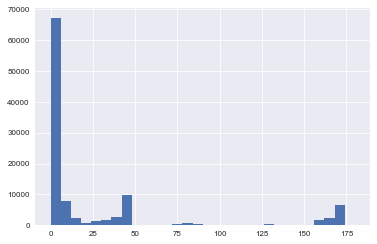

In [55]:
plt.hist(diffs_within, bins=30);

In [234]:
%%cython -a
# cython: wraparound=False
# cython: boundscheck=False

import numpy as np 
cimport numpy as np
import scipy


cdef int pair_diffs(np.int8_t[:] hi, np.int8_t[:] hj):
    cdef:
        int i, n, v
    n = hi.shape[0]
    v = 0
    for i in range(n):
        v += (hi[i] != hj[i])
    return v
    


def pairwise_diffs_between(np.int8_t[:, :] h1, np.int8_t[:, :] h2):
    assert h1.ndim == h2.ndim == 2
    cdef:
        int i, j, n1, n2
        np.int32_t[:, :] out
    n1 = h1.shape[1]
    n2 = h2.shape[1]
    out = np.empty((n1, n2), dtype='i4')
    for i in range(n1):
        for j in range(n2):
            out[i, j] = pair_diffs(h1[:, i], h2[:, j])
    return np.asarray(out)
            

In [235]:
h1 = np.asarray(haps_ehh[:1000].take(vgsc_haplogroups['F1'], axis=1))
h2 = np.asarray(haps_ehh[:1000].take(vgsc_haplogroups['F5'], axis=1))

In [236]:
pair_diffs(h1[:, 0], h2[:, 1])

12

In [237]:
%time diffs_between = pairwise_diffs_between(h1, h2)

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 173 ms


In [238]:
diffs_between

array([[  9,  12,   9, ...,   9,   9,   8],
       [ 32,  35,  32, ...,  32,  32,  33],
       [174, 175, 174, ..., 174, 174, 173],
       ..., 
       [  8,  13,   8, ...,   8,   8,   9],
       [  8,  13,   8, ...,   8,   8,   9],
       [  9,  12,   9, ...,   9,   9,   8]], dtype=int32)

In [239]:
dbf = diffs_between.flatten()

In [240]:
dbf.shape

(90944,)

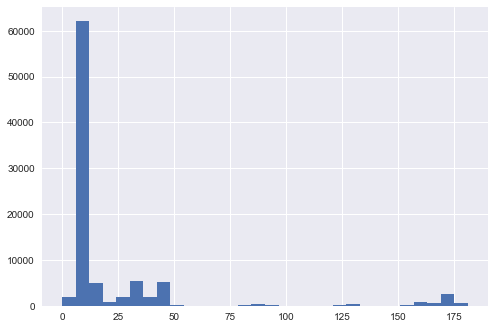

In [241]:
plt.hist(dbf, bins=30);

In [242]:
np.count_nonzero(dbf > 0) / dbf.shape[0]

0.9989554011259676

In [243]:
loc = pos_ehh.locate_range(1500000, 3500000)
loc

slice(7641, 60431, None)

In [386]:
h = haps_ehh[loc].take(vgsc_haplogroups['F5'], axis=1)
h

<HaplotypeArray shape=(52790, 196) dtype=int8>
1 1 1 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [387]:
p = pos_ehh[loc]
p

0,1,2,3,4,...,52785,52786,52787,52788,52789
1502639,1502975,1502988,1502989,1502990,...,3499899,3499913,3499927,3499934,3499996


In [388]:
result = allel.moving_statistic(values=h, statistic=lambda v: allel.pairwise_distance(v, metric='hamming') * v.shape[0], size=1000, step=200)
result.shape

(259, 19110)

In [389]:
result

array([[ 1.,  1.,  1., ...,  0.,  2.,  2.],
       [ 2.,  1.,  1., ...,  0.,  1.,  1.],
       [ 2.,  1.,  1., ...,  1.,  1.,  2.],
       ..., 
       [ 4.,  1.,  0., ...,  0.,  1.,  1.],
       [ 0.,  1.,  0., ...,  0.,  1.,  1.],
       [ 0.,  1.,  0., ...,  0.,  1.,  1.]])

In [390]:
midpoints = allel.moving_statistic(values=p, statistic=np.mean, size=1000, step=200)

In [391]:
midpoints.shape

(259,)

In [392]:
x = np.empty(result.shape, dtype=int)
x[:] = midpoints[:, None]
x

array([[1536176, 1536176, 1536176, ..., 1536176, 1536176, 1536176],
       [1547278, 1547278, 1547278, ..., 1547278, 1547278, 1547278],
       [1558610, 1558610, 1558610, ..., 1558610, 1558610, 1558610],
       ..., 
       [3486959, 3486959, 3486959, ..., 3486959, 3486959, 3486959],
       [3488582, 3488582, 3488582, ..., 3488582, 3488582, 3488582],
       [3489947, 3489947, 3489947, ..., 3489947, 3489947, 3489947]])

In [393]:
sns.set_context('notebook')
palette = sns.color_palette()

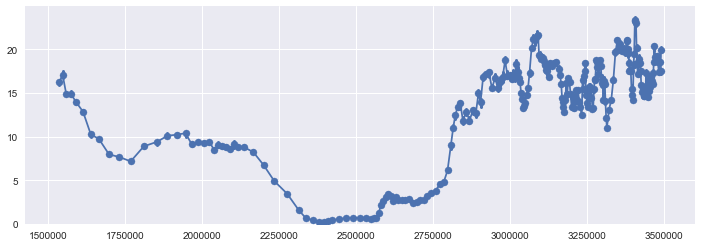

In [394]:
fig, ax = plt.subplots(figsize=(12, 4))
mx = x[:, 0]
my = result.mean(axis=1)
ax.plot(mx, my, color=palette[0])
sns.regplot(x=x.flatten(), y=result.flatten(), n_boot=10, scatter=True, fit_reg=False, x_estimator=np.mean, ax=ax, color=palette[0])
ax.set_ylim(bottom=0);

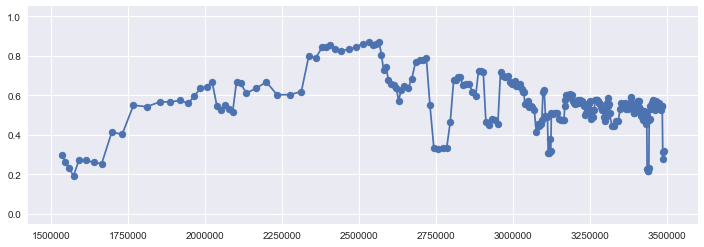

In [395]:
fig, ax = plt.subplots(figsize=(12, 4))
mx = x[:, 0]
my = (result == 0).sum(axis=1) / result.shape[1]
ax.plot(mx, my, color=palette[0])
sns.regplot(x=x.flatten(), y=result.flatten(), n_boot=10, scatter=True, fit_reg=False, x_estimator=lambda v: (len(v) - np.count_nonzero(v)) / len(v), ax=ax, color=palette[0])
ax.set_ylim(-0.05, 1.05);

In [297]:
h1 = np.asarray(haps_ehh[loc].take(vgsc_haplogroups['S4'], axis=1))
h2 = np.asarray(haps_ehh[loc].take(vgsc_haplogroups['S5'], axis=1))
h1.shape, h2.shape

((52790, 37), (52790, 36))

In [298]:
h1.shape[1] * h2.shape[1]

1332

In [299]:
windows = list(allel.stats.window.index_windows(h1, size=1000, step=200, start=0, stop=None))
len(windows)

259

In [300]:
result = np.array([pairwise_diffs_between(h1[i:j], h2[i:j]).flatten() for i, j in windows])
result.shape

(259, 1332)

In [301]:
x = np.empty(result.shape, dtype=int)
x[:] = midpoints[:, None]
x.shape

(259, 1332)

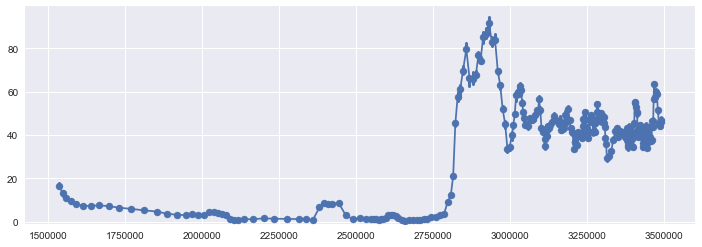

In [302]:
fig, ax = plt.subplots(figsize=(12, 4))
mx = x[:, 0]
my = result.mean(axis=1)
ax.plot(mx, my, color=palette[0])
sns.regplot(x=x.flatten(), y=result.flatten(), n_boot=10, scatter=True, fit_reg=False, x_estimator=np.mean, ax=ax, color=palette[0])
ax.set_ylim(bottom=-1);

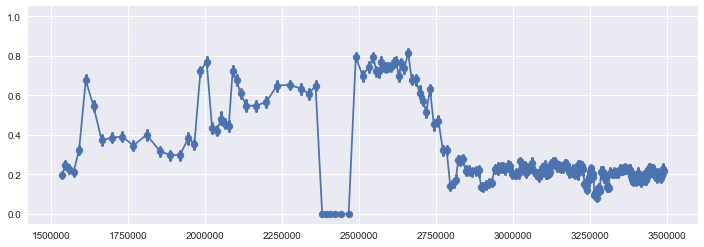

In [304]:
fig, ax = plt.subplots(figsize=(12, 4))
mx = x[:, 0]
my = (result == 0).sum(axis=1) / result.shape[1]
ax.plot(mx, my, color=palette[0])
sns.regplot(x=x.flatten(), y=result.flatten(), n_boot=100, scatter=True, fit_reg=False, x_estimator=lambda v: (len(v) - np.count_nonzero(v)) / len(v), ax=ax, color=palette[0])
ax.set_ylim(-0.05, 1.05);